In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(13)
%load_ext autoreload
%autoreload 2

In [3]:
# Number of sources
r=5
# Number of mixtures
M=10
# Number of samples
N=500000
# Number of Iterations
NumberofIterations=5000
# Number of Averages
NumAverages=1
# SNR level
SNR=30 #dB
NoiseAmp=(10**(-SNR/20))*np.sqrt(r)

In [4]:
#Define number of sampling points
n_samples = N
#Degrees of freedom
df = 4

# Correlation values
rholist=np.array([0.0, 0.1, 0.2,0.3,0.4,0.5,0.6,0.7])
rholist=[0.5]
SIRLDInfoMax=np.zeros((len(rholist),NumAverages))
SIRLDInfoMaxW=np.zeros((len(rholist),NumAverages))
SIRICAInfoMax=np.zeros((len(rholist),NumAverages))
SIRLDInfoMaxList=np.zeros((NumAverages,NumberofIterations))

In [5]:
rho=0.5
calib_correl_matrix = np.eye(r)*(1-rho)+rho*np.ones((r,r))
mu = np.zeros(len(calib_correl_matrix))

#######################################################
#              GENERATE SOURCES                       #
#######################################################
s = chi2.rvs(df, size=n_samples)[:, np.newaxis] 
Z = np.random.multivariate_normal(mu, calib_correl_matrix,n_samples)
X = np.sqrt(df/s)*Z #chi-square method
# Copula-t distriution with df degrees of freedom
U = t.cdf(X,df).T
# Generate correlated unity variance sources
S=U#*np.sqrt(12)
S = 2*S - 1


#######################################################
#              GENERATE MIXINGS                       #
#######################################################
# Generate Mxr random mixing from i.i.d N(0,1)
Hm=np.random.randn(M,r)
# Mixtures
HS=np.dot(Hm,S)
NoisePart=NoiseAmp*np.random.randn(HS.shape[0],HS.shape[1])
X=HS+NoisePart
SNRinp=10*np.log10(np.sum(np.var(HS,axis=1))/np.sum(np.var(NoisePart,axis=1)))

# Mean of Mixtures
mX=np.mean(X,axis=1).reshape((M,1))
# Covariance of Mixtures
Rxx=np.dot(X,X.T)/N-np.dot(mX,mX.T)
# Eigenvalue Decomposition
d,V=np.linalg.eig(Rxx)
D=np.diag(d)
#Sorting indexis for eigenvalues from large to small
ie=np.argsort(-d)
# Inverse square root of eigenvalues
ddinv=1/np.sqrt(d[ie[:r]])
# Prewhitining matrix
Wpre=np.dot(np.diag(ddinv),V[:,ie[:r]].T)/np.sqrt(12)
# Whitened Mixtures
H=np.dot(Wpre,X)

In [6]:
display_matrix(np.corrcoef(H))

<IPython.core.display.Math object>

In [7]:
X = H
A = Wpre @ Hm

In [8]:
lambday = 1 - 1e-5/10
lambdae = 1 - 1e-6/10

s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 50 * np.eye(s_dim)

debug_iteration_point = 1000
model = OnlineLDMIBSS(s_dim = s_dim, x_dim = x_dim, muW = 1e-3, lambday = lambday,
                      lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-7,
                      set_ground_truth = True, S = S, A = A)

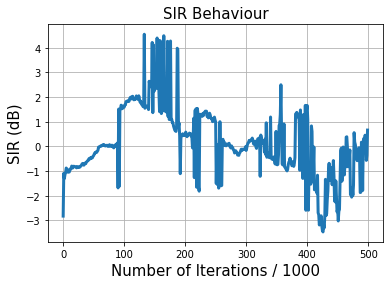

100%|█████████████████████████████████| 500000/500000 [05:40<00:00, 1467.54it/s]


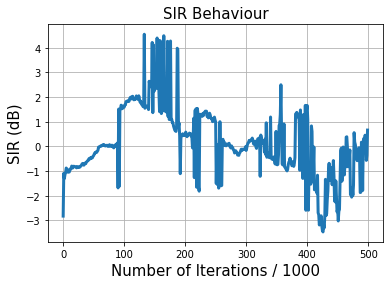

In [9]:
model.fit_batch_antisparse(X = X, n_epochs = 1, neural_dynamic_iterations = 250,
                           plot_in_jupyter = True, neural_lr_start = .1,
                           neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                          shuffle = True)